# Creating AIA Data Cubes

This notebook will demonstrate how to calculate level 1.5 images and construct AIA data cubes.

We'll use Dask to map our prep functions across all of our files and send these computations out to the workers in our cluster. Then, we'll collect each of these images and stack them into a single data cube. 

This data structure holds all of the metadata for our observation in memory, but pushes the actual data either into the memory of the distributed Dask cluster  or leaves the files on disk.

This allows us to do expensive computation on large datasets that do not fit in memory, while performing our analysis in a similar manner to how we would on a desktop or laptop computer.

In [55]:
import glob
import warnings
warnings.simplefilter(action='ignore', category=UserWarning)
import sys
import copy
import os

import yaml
import numpy as np
import matplotlib.pyplot as plt
import dask
import distributed
import dask_jobqueue
from dask_jobqueue import PBSCluster
import astropy.units as u
from astropy.coordinates import SkyCoord
from astropy.visualization import ImageNormalize, AsinhStretch
import sunpy.map
from aiapy.calibrate import register
import ndcube

import aiacube
from aiacube.prep import normalize_to_exposure_time, derotate
sys.path.append('../../scripts/')
from drms_on_ames import Client

%matplotlib inline

## Querying Data

In a [previous notebook](querying-sdo-data.ipynb), we showed an example of how to query AIA data using drms at Ames and return a list of file paths. We'll do the same here for a 2 hour block of data. This time, we'll select only the 171 channel.

In [2]:
c = Client(ssh=True)  # ssh=true only if not running on dfe1

Note that we can also request specific keys and further filter our results based on those key values.

In [3]:
key, q = c.query(
    'aia.lev1[2017-09-10T15:30:00/2h]',
    seg=['image_lev1'],
    key=['WAVELNTH']
)
files = (q[key['WAVELNTH']==171]
         .values
         .squeeze()
         .tolist()
        )

Since we are querying at a cadence of 12 s for 2 hours, we should have a total of 600 files for a single channel.

In [4]:
len(files)

600

## Cluster Setup

We want to send all of our computation off to the nodes in our cluster rather than this notebook. To do this, we first need to setup a Dask cluster.

In [5]:
with open('../../jobqueue-electra-skylake.yml','r') as f:
    config = yaml.load(f)['jobqueue']['pbs']

/home4/wtbarnes/miniconda3/envs/aia-on-pleiades/lib/python3.7/site-packages/ipykernel_launcher.py:2: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  


In [6]:
cluster = PBSCluster(**config)

*(**NOTE:** This setup may need to be customized depending on the hardware you're using. The above configuration is for Merope and is read from the configuration file in `$HOME/.config/dask/jobqueue.yml`.)*

Then, create a client for the cluster.

In [7]:
client = distributed.Client(cluster)

Note that the Dask cluster, unlike traditional HPC schedulers (e.g. PBS) is not persistent, meaning we need to create it each time we start our analysis.

Lastly, we'll add some workers to our cluster so that we can actually do some computation!

In [8]:
client

<Client: 'tcp://10.150.54.120:40259' processes=0 threads=0, memory=0 B>

In [9]:
cluster.scale(5)

## Preprocess Images

First, we need create maps from our files. Note that if we read all of these files from disk into our local memory, we'd run into a problem as these datasets can be many 100s of GB in size. Instead, we'll create our `Map` objects in the memory of our distributed cluster by "mapping" the `Map` creating across all of our files using our `client`.

In [26]:
maps = client.map(sunpy.map.Map, files, pure=True)

If we look at the first entry of the result, we see that this function returns a list of `Future` objects.

In [27]:
maps[0]

<Future: status: finished, type: AIAMap, key: <sunpy.map.map_factory.MapFactory object at 0x7fff33ec0d30>-251cb52766ee70062ee7c1519f6b5a98>

This object tells us the state of our task in the cluster and keeps track of its progress. Note that this returns immediately while our task is running in the cluster. This gives us the ability to add more workers if we find that our computation load is greater than expected.

Next, we'll apply our prep and normalize operations to all of our maps. This converts our level 1 AIA 171 images into level 1.5 data products. We can do this directly by just passing our `Map` futures to another `client.map` call.

In [57]:
maps_prep = client.map(register, maps, pure=True, order=3,)

Furthermore, we can continue to chain these calls as they are non-blocking, i.e. they return immediately. This last step normalizes to the exposure time of the telescope.

In [58]:
maps_level_15 = client.map(normalize_to_exposure_time, maps_prep)

Finally, we'll remove the effect of solar rotation in each image by "derotating" all images to 
the first image.

In [59]:
maps_derotate = client.map(derotate,
                           maps_level_15,
                           ref_map=maps_level_15[0],
                           rot_type='snodgrass',
                          )

We've given our cluster a lot of work to do. Let's throw a bunch more workers at it to speed things up.

In [15]:
cluster.scale(20)

## Stacking Images to Create an NDCube

Thus far, we only have a list of maps. Ideally, we'd like to work with three-dimensional data "cubes" over which we can perform coordinate-aware slicing and visualization.

Fortunately, the [`ndcube`]() package provides such an interface. `ndcube` holds all of the data and World Coordinate System (WCS) information in a single container and is capable of slicing the data and WCS.

To construct an `ndcube.NDCube` object from our list of futures from above,

In [60]:
cube = aiacube.AIACube.from_futures(maps_derotate)

Changed DATE-OBS from '2017-09-10 15:30:09.350' to '2017-09-10T15:30:09.350''. [astropy.wcs.wcs]


In [61]:
cube

NDCube
---------------------
WCS Keywords

Number of WCS axes: 3
CTYPE : 'HPLN-TAN'  'HPLT-TAN'  'TIME'  
CRVAL : 0.0  0.0  0.0  
CRPIX : 2048.5  2048.5  1.0  
PC1_1 PC1_2 PC1_3  : 1.0  -6.3604258927531e-20  0.0  
PC2_1 PC2_2 PC2_3  : -2.6249188018676e-20  1.0  0.0  
PC3_1 PC3_2 PC3_3  : 0.0  0.0  1.0  
CDELT : 0.00016666666666667  0.00016666666666667  12.00000000000188  
NAXIS : 4096  4096  600
---------------------
Length of NDCube: [ 600. 4096. 4096.] pix
Axis Types of NDCube: ('time', 'custom:pos.helioprojective.lat', 'custom:pos.helioprojective.lon')

Note that we can easily look at the metadata and associated WCS for this object. Note that this is quite a large chunk of data and in fact the data that "backs" this object is stored not in the local memory of this notebook, but in the memory of the cluster.

In [62]:
cube.data

dask.array<stack, shape=(600, 4096, 4096), dtype=float64, chunksize=(1, 4096, 4096), chunktype=numpy.ndarray>

As we can see from the information Dask gives us about our array, this chunk of data is over 80 GB.

Even though this array is actually stored in the memory of the cluster, we can manipulate it as if it were in local memory. For example, to plot a single image,

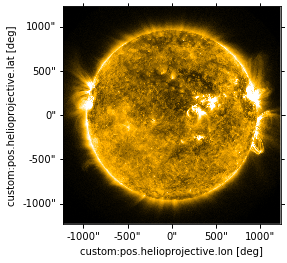

In [63]:
# NOTE: ndcube follows WCS ordering of indices. In this case: time, lat, lon
cube[0,:,:].plot(cmap='sdoaia171',
                 norm=ImageNormalize(vmin=0, vmax=5e2, stretch=AsinhStretch()))

Because our `NDCube` object is coordinate aware, we can also slice our array using physical coordinates.

In [64]:
subcube = cube.crop_by_coords(
    lower_corner=(0*u.s, -500*u.arcsec, 600*u.arcsec),
    upper_corner=(2.1*u.h, 100*u.arcsec, 1200*u.arcsec)
)

In [65]:
subcube

NDCube
---------------------
WCS Keywords

Number of WCS axes: 3
CTYPE : 'HPLN-TAN'  'HPLT-TAN'  'TIME'  
CRVAL : 0.0  0.0  0.0  
CRPIX : -998.5  834.5  1.0  
PC1_1 PC1_2 PC1_3  : 1.0  -6.3604258927531e-20  0.0  
PC2_1 PC2_2 PC2_3  : -2.6249188018676e-20  1.0  0.0  
PC3_1 PC3_2 PC3_3  : 0.0  0.0  1.0  
CDELT : 0.00016666666666667  0.00016666666666667  12.00000000000188  
NAXIS : 1002  1002  600
---------------------
Length of NDCube: [ 600. 1002. 1002.] pix
Axis Types of NDCube: ('time', 'custom:pos.helioprojective.lat', 'custom:pos.helioprojective.lon')

In [66]:
subcube.data

dask.array<getitem, shape=(600, 1002, 1002), dtype=float64, chunksize=(1, 1002, 1002), chunktype=numpy.ndarray>

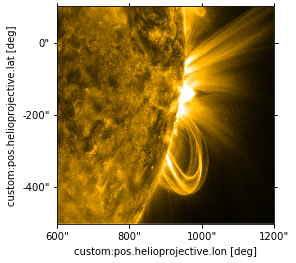

In [67]:
subcube[150,:,:].plot(
    cmap='sdoaia171',
    norm=ImageNormalize(vmin=0, vmax=8e2, stretch=AsinhStretch()))

Furthermore, we can also slice the array along the time axis to extract a timeseries for a particular pixel. However, this slice is perpendicular to the direction that we've chunked our array (as seen in the above glyphs). This means that a slice in the time direction would require reading every single chunk in our array, a very inefficient way to read a single pixel as a function of time!

Fortunately, Dask provides an interface for rechunking our array to avoid these inefficient read operations.

In [68]:
cube_rechunked = aiacube.AIACube(
    cube.data.rechunk(cube.data.shape[:1] + (200,200)),
    cube.wcs,
    meta=cube.meta,
    unit=cube.unit
)

In [69]:
cube_rechunked.data

dask.array<rechunk-merge, shape=(600, 4096, 4096), dtype=float64, chunksize=(600, 200, 200), chunktype=numpy.ndarray>

Note that we have many tall and skinny chunks meaning we can read slices in time without touching every other pixel in space.

Let's create a slice for a pixel right off the limb where the flare occurred. We can use the coordinates machinery in `astropy.coordinates` to overplot the coordinate on our image.

In [70]:
slice_171 = subcube[0,:,:]
m = slice_171.maps[0]

In [71]:
coord = SkyCoord(Tx=950*u.arcsec, Ty=-150*u.arcsec, frame=m.coordinate_frame)

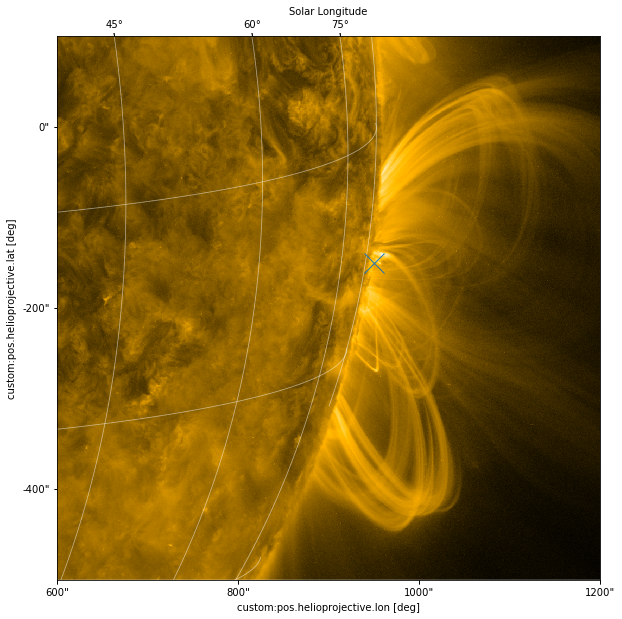

In [72]:
fig = plt.figure(figsize=(10,10))
ax = fig.gca(projection=m)
slice_171.plot(**m.plot_settings)
ax.plot_coord(coord, markersize=20, marker='x', color='C0')
warnings.simplefilter(action='ignore', category=RuntimeWarning)
m.draw_grid(axes=ax)

We can then use the `world_to_pixel` method on our cube to convert between integer indices and physical coordinates.

In [73]:
_,y,x = cube_rechunked.world_to_pixel(
    0*u.s,
    coord.Ty,
    coord.Tx,
)

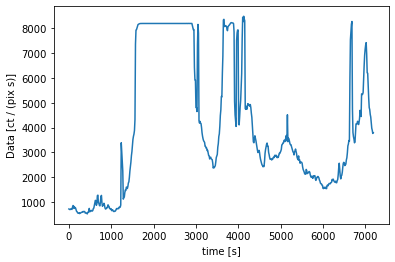

In [74]:
cube_rechunked[:,int(y.value),int(x.value)].plot()

Note that the intensity is completely saturated during flare, between about $t=1500$ s and $t=3000$ s.